# 3C6 – Ejercicio 2: Regresión múltiple

En este cuaderno se desarrolla el ejercicio 2 de la práctica de regresión. El objetivo principal es construir y evaluar distintos modelos de regresión múltiple capaces de predecir la concentración de benceno `C6H6(GT)` a partir de variables relacionadas con la calidad del aire y las condiciones meteorológicas.


## Introducción y planteamiento del problema

La ciudad de Madrid cuenta con una red de sensores que registra de forma horaria distintos contaminantes atmosféricos y algunas variables meteorológicas. En este ejercicio trabajamos con un subconjunto de estas mediciones para estudiar hasta qué punto es posible predecir la concentración de benceno `C6H6(GT)` a partir de otros contaminantes y de la información de los sensores.

El objetivo del cuaderno es entrenar y comparar varios modelos de regresión múltiple (regresión lineal, regresión Ridge y Random Forest) y analizar qué variables tienen mayor influencia en la concentración de benceno, qué porcentaje de variabilidad explica el mejor modelo y cuáles son las principales limitaciones del enfoque seguido.


## Carga inicial de datos

En esta sección se cargan los datos originales desde el fichero CSV y se realiza una inspección rápida del contenido. Se comprueba el número de filas y columnas, se visualizan algunas filas de ejemplo, se revisan los tipos de datos y el número de valores nulos por columna. Además, se detectan posibles valores especiales como `-200`, que en este dataset se utilizan como códigos de error de los sensores.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Cargar el CSV (ajustar la ruta si el fichero está en otra carpeta)
ruta_csv = "air_quality.csv"

df = pd.read_csv(
    ruta_csv,
    sep=';',      # separador de columnas
    decimal=','   # separador decimal
)

# Tamaño del dataset
print("\nTamaño del dataset (filas, columnas):", df.shape)

# Primeras filas
print("\nPrimeras 5 filas del dataset:")
print(df.head())

# Información general: tipos de datos y no nulos
print("\nInformación general del DataFrame:")
df.info()

# Resumen estadístico de columnas numéricas
print("\nResumen estadístico de las columnas numéricas:")
print(df.describe())

# Valores nulos por columna
print("\nNúmero de valores nulos por columna:")
print(df.isna().sum())

# Nombres de las columnas (para detectar columnas raras)
print("\nNombres de todas las columnas:")
print(df.columns.tolist())

# Comprobación rápida de valores especiales (como -200) en columnas clave
columnas_a_comprobar = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

for columna in columnas_a_comprobar:
    if columna in df.columns:
        valores_unicos = sorted(df[columna].dropna().unique())
        print(f"\nPrimeros 15 valores únicos en '{columna}':")
        print(valores_unicos[:15])
    else:
        print(f"\n[AVISO] La columna '{columna}' no está en el DataFrame.")



Tamaño del dataset (filas, columnas): (9471, 17)

Primeras 5 filas del dataset:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15 

## Análisis exploratorio de los datos

Antes de entrenar modelos de regresión es conveniente explorar visualmente las distribuciones de las variables y sus relaciones con la variable objetivo `C6H6(GT)`. En esta sección se muestran histogramas y diagramas de caja de las variables numéricas, un mapa de calor de correlaciones y algunas gráficas de dispersión entre variables relevantes y la concentración de benceno.


Número de columnas numéricas: 15


<Figure size 1200x1000 with 0 Axes>

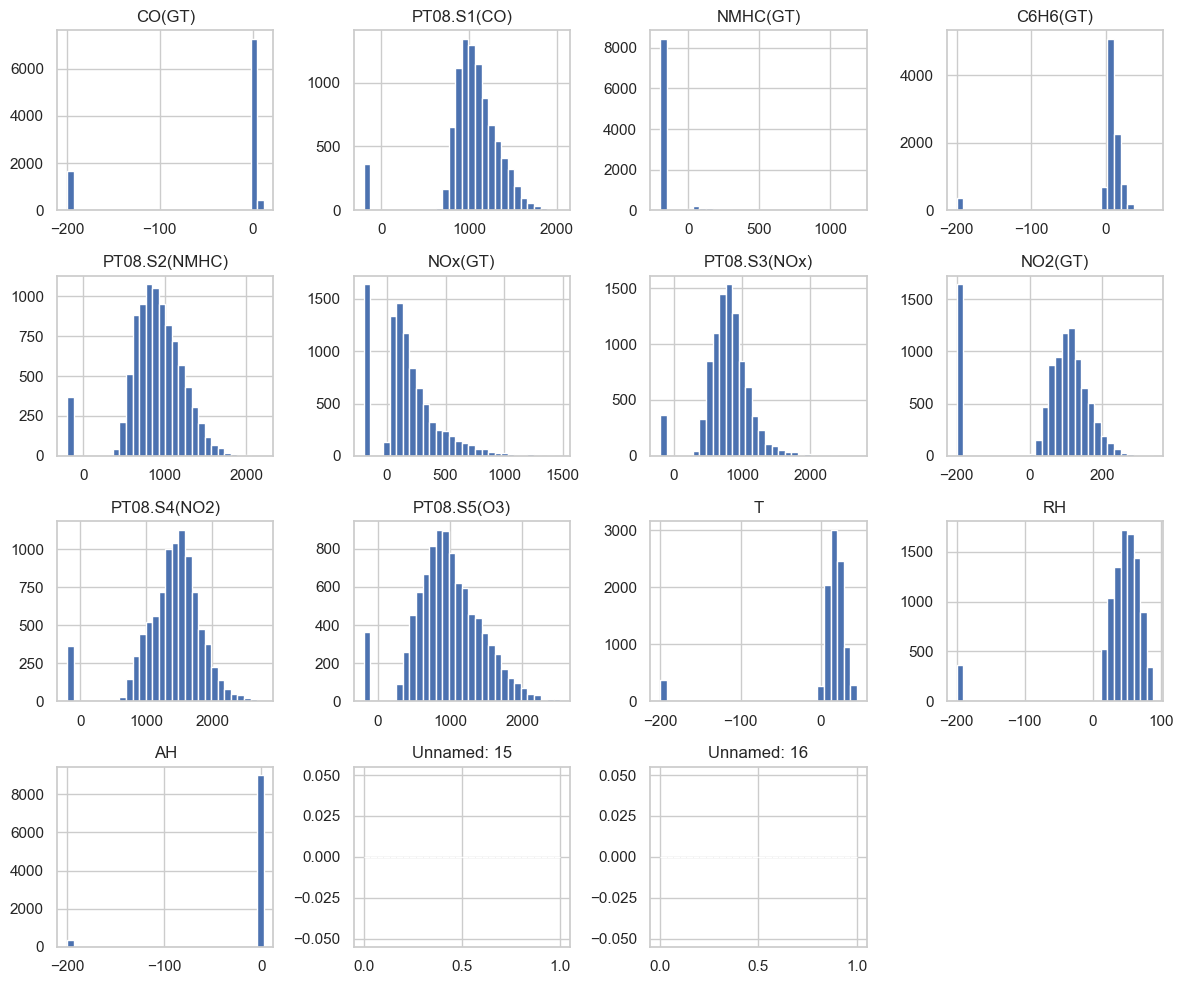

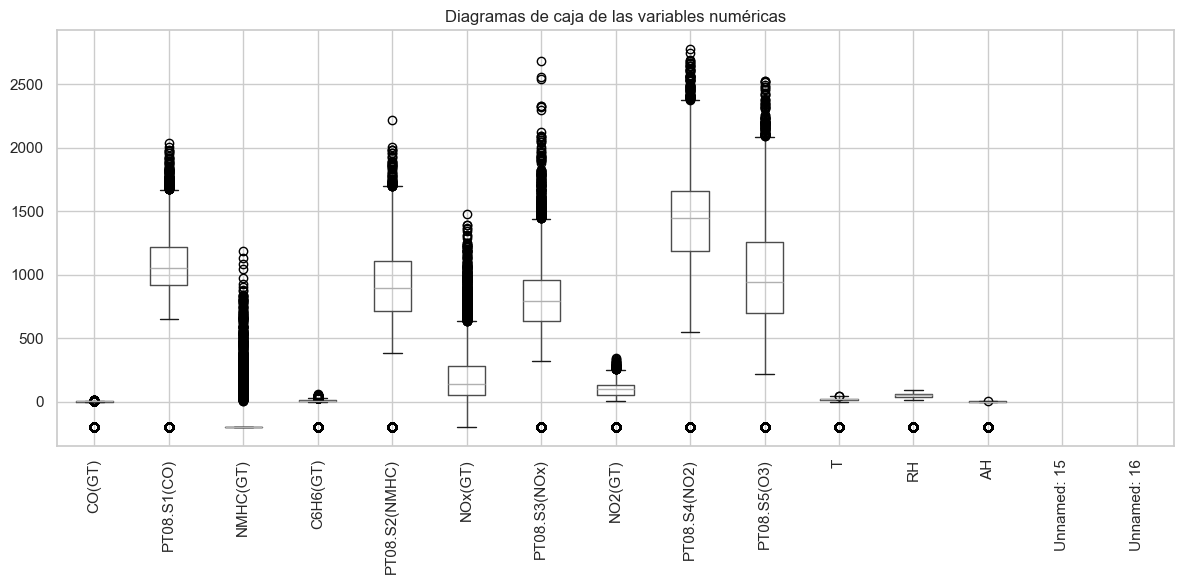

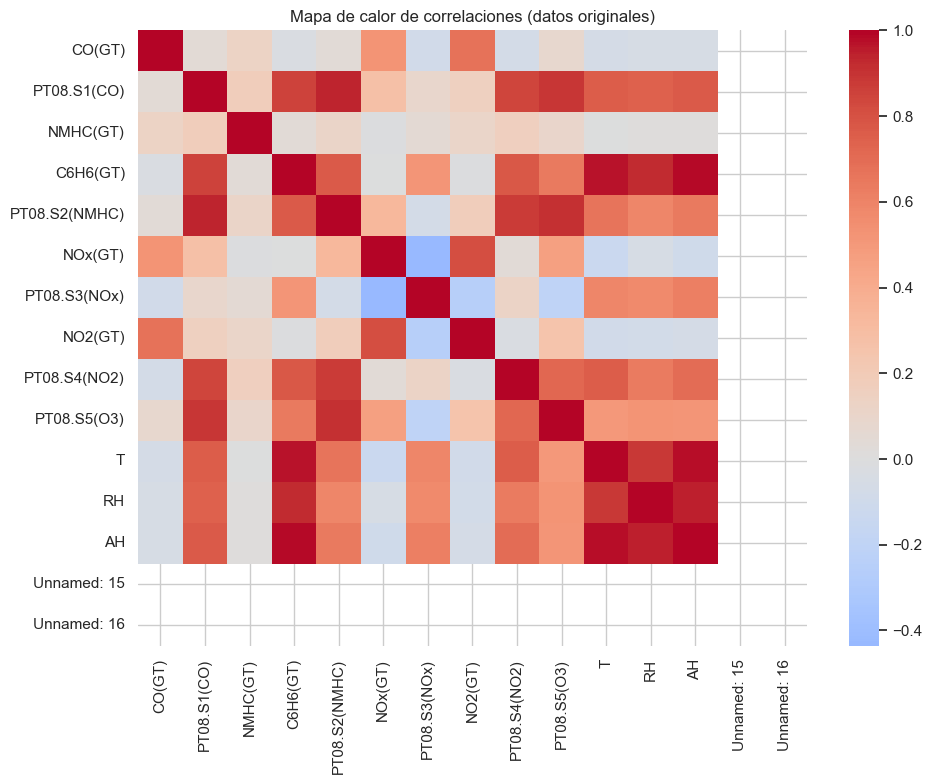

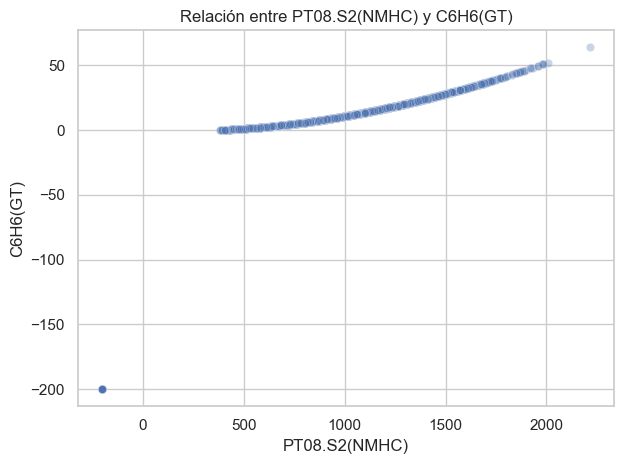

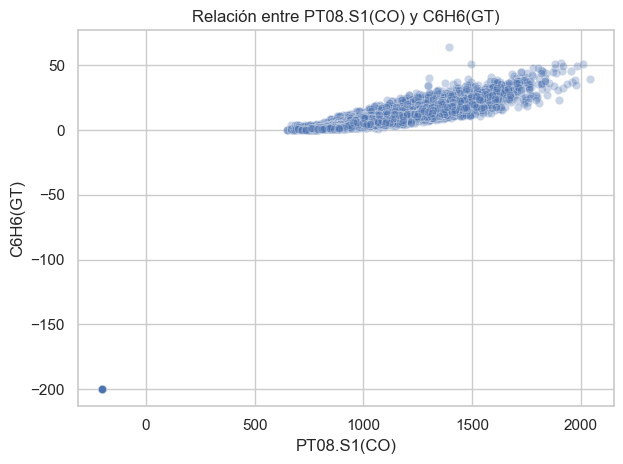

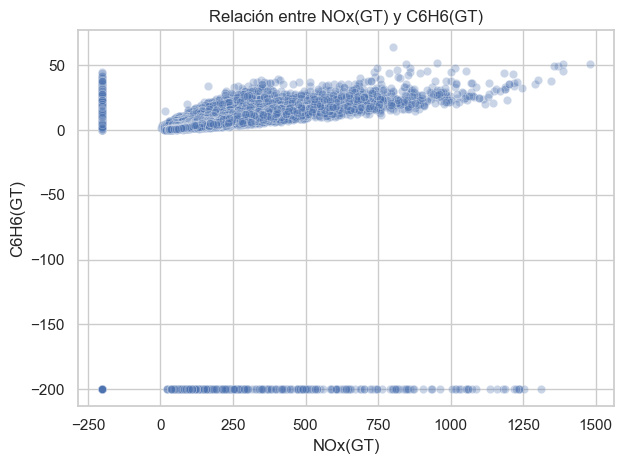

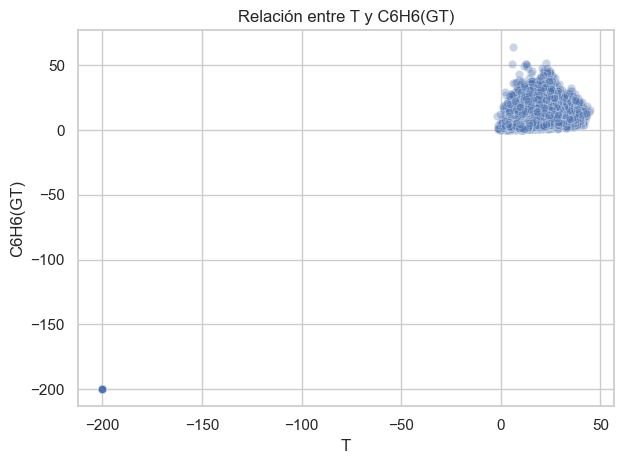

In [2]:
# Seleccionar columnas numéricas
columnas_numericas = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

print("Número de columnas numéricas:", len(columnas_numericas))

# Histograma de las variables numéricas
plt.figure(figsize=(12, 10))
df[columnas_numericas].hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

# Diagramas de caja para detectar valores atípicos
plt.figure(figsize=(12, 6))
df[columnas_numericas].boxplot(rot=90)
plt.title("Diagramas de caja de las variables numéricas")
plt.tight_layout()
plt.show()

# Mapa de calor de correlaciones
plt.figure(figsize=(10, 8))
matriz_corr = df[columnas_numericas].corr()
sns.heatmap(matriz_corr, cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones (datos originales)")
plt.tight_layout()
plt.show()

# Dispersión de algunas variables frente a C6H6(GT)
if "C6H6(GT)" in df.columns:
    vars_interes = [col for col in ["PT08.S2(NMHC)", "PT08.S1(CO)", "NOx(GT)", "T"] if col in df.columns]
    for col in vars_interes:
        plt.figure()
        sns.scatterplot(data=df, x=col, y="C6H6(GT)", alpha=0.3)
        plt.title(f"Relación entre {col} y C6H6(GT)")
        plt.tight_layout()
        plt.show()
else:
    print("La columna 'C6H6(GT)' no está disponible para las gráficas de dispersión.")


## Limpieza de datos y selección de variables

Una vez explorados los datos brutos se realiza una limpieza básica para dejar el conjunto de datos listo para la regresión múltiple. En primer lugar se sustituyen los valores `-200` por `NaN`, ya que se utilizan como códigos de error de los sensores. A continuación se crea una nueva variable `Hour` a partir de la columna `Time` para recoger la hora del día. Finalmente se define la variable objetivo `C6H6(GT)` y se selecciona un conjunto de variables predictoras que incluyen otros contaminantes, las respuestas de los sensores y algunas variables meteorológicas. Tras eliminar las filas con valores ausentes en estas columnas se conservan 827 registros válidos de las 9471 filas originales, de modo que solo se utiliza alrededor de un 9 % de las observaciones. Esta reducción del tamaño muestral se tendrá en cuenta más adelante como una de las limitaciones del modelo.


Variables predictoras que se usarán:
['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour']

Filas antes de dropna: 9471
Filas después de dropna: 827

Primeras filas de df_model (datos listos para train/test):
   CO(GT)  PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0     2.6       1360.0     150.0         1046.0    166.0        1056.0   
1     2.0       1292.0     112.0          955.0    103.0        1174.0   
2     2.2       1402.0      88.0          939.0    131.0        1140.0   
3     2.2       1376.0      80.0          948.0    172.0        1092.0   
4     1.6       1272.0      51.0          836.0    131.0        1205.0   

   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  Hour  C6H6(GT)  
0    113.0        1692.0       1268.0  13.6  48.9  0.7578  18.0      11.9  
1     92.0        1559.0        972.0  13.3  47.7  0.7255  19.0       9.4  
2    114.0        1555.

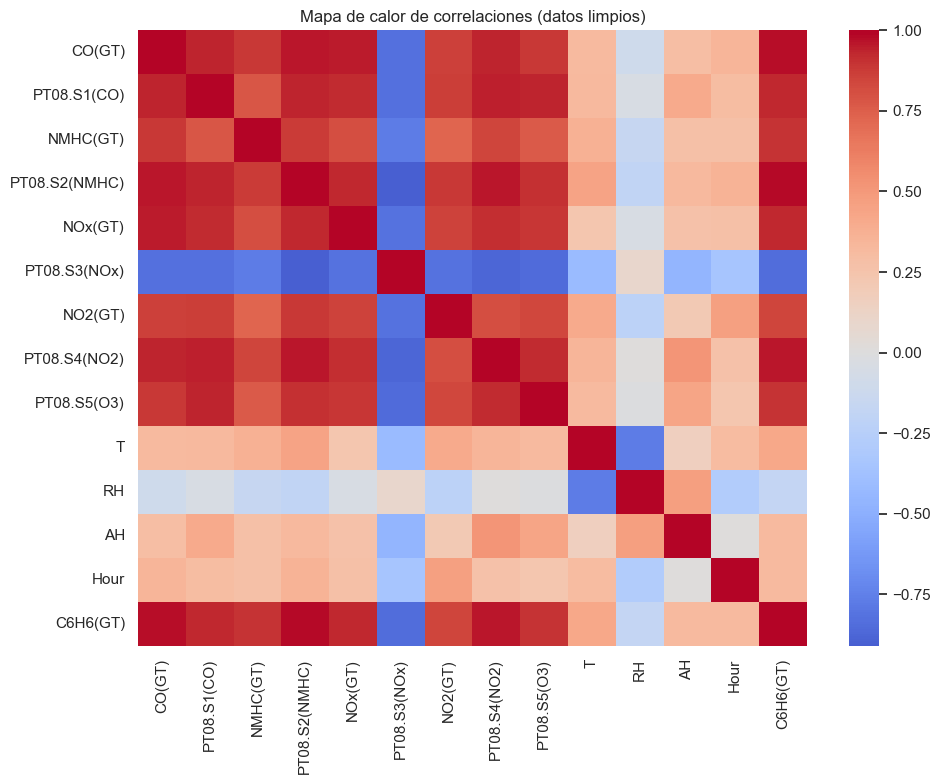

In [3]:
# Sustituir -200 por NaN (código de error del sensor)
df = df.replace(-200, np.nan)

# Crear columna Hour a partir de Time (solo la hora del día)
if "Time" in df.columns:
    df["Hour"] = pd.to_datetime(df["Time"], format="%H.%M.%S", errors="coerce").dt.hour
else:
    print("Aviso: no existe la columna 'Time' en el DataFrame.")

# Definir variable objetivo y lista de variables predictoras
target_col = "C6H6(GT)"

feature_cols = [
    "CO(GT)",
    "PT08.S1(CO)",
    "NMHC(GT)",
    "PT08.S2(NMHC)",
    "NOx(GT)",
    "PT08.S3(NOx)",
    "NO2(GT)",
    "PT08.S4(NO2)",
    "PT08.S5(O3)",
    "T",
    "RH",
    "AH",
    "Hour",
]

# Filtrar solo columnas que existan realmente en el DataFrame (por seguridad)
feature_cols_presentes = [col for col in feature_cols if col in df.columns]

print("Variables predictoras que se usarán:")
print(feature_cols_presentes)

# Comprobar que la columna objetivo existe
if target_col not in df.columns:
    raise ValueError(f"La columna objetivo '{target_col}' no existe en el DataFrame.")

# Crear DataFrame con las variables seleccionadas
df_model = df[feature_cols_presentes + [target_col]].copy()

# Eliminar filas con valores nulos en cualquier columna seleccionada
print("\nFilas antes de dropna:", df_model.shape[0])
df_model = df_model.dropna()
print("Filas después de dropna:", df_model.shape[0])

# Vista rápida del DataFrame preparado
print("\nPrimeras filas de df_model (datos listos para train/test):")
print(df_model.head())

# Matriz de correlación sobre el conjunto ya limpio
plt.figure(figsize=(10, 8))
matriz_corr_limpia = df_model.corr()
sns.heatmap(matriz_corr_limpia, cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones (datos limpios)")
plt.tight_layout()
plt.show()

# Guardar X (predictoras) e y (objetivo) para usarlos más adelante
X = df_model[feature_cols_presentes]
y = df_model[target_col]


## Separación en entrenamiento y prueba

Para poder evaluar los modelos de forma honesta, el conjunto de datos limpio se divide en dos subconjuntos: uno de entrenamiento y otro de prueba. El modelo aprende a partir de los datos de entrenamiento y posteriormente se evalúa sobre el conjunto de prueba, que actúa como datos no vistos. En este cuaderno se utiliza una partición del 80 % de las observaciones para entrenamiento y el 20 % restante para prueba, fijando una semilla aleatoria para garantizar la reproducibilidad.


In [4]:
# Separar los datos en entrenamiento (train) y prueba (test)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% para test
    random_state=42     # semilla para reproducibilidad
)

# Mostrar tamaños de cada subconjunto
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test: ", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test: ", y_test.shape)


Tamaño X_train: (661, 13)
Tamaño X_test:  (166, 13)
Tamaño y_train: (661,)
Tamaño y_test:  (166,)


## Entrenamiento de modelos de regresión

A continuación se entrenan tres modelos de regresión múltiple sobre los datos de entrenamiento: un modelo de regresión lineal basada en mínimos cuadrados, un modelo de regresión Ridge (con regularización) y un modelo de Random Forest para regresión. Todos los modelos se evalúan sobre el conjunto de prueba utilizando métricas estándar de regresión (MAE, MSE, RMSE y R²) y se generan gráficas de valores reales frente a valores predichos y de residuos para analizar su comportamiento.


### Modelo de regresión lineal

El primer modelo es una regresión lineal múltiple (`LinearRegression`). Este modelo asume una relación lineal entre las variables predictoras y la variable objetivo `C6H6(GT)`. Tras el entrenamiento se calculan las métricas de error sobre el conjunto de prueba y se representan gráficamente los valores reales frente a los valores predichos, así como la distribución de los residuos (diferencia entre valor real y valor predicho).


Resultados modelo LinearRegression:
MAE  (error absoluto medio): 0.472
MSE  (error cuadrático medio): 0.425
RMSE (raíz del error cuadrático medio): 0.652
R²   (variabilidad explicada): 0.993


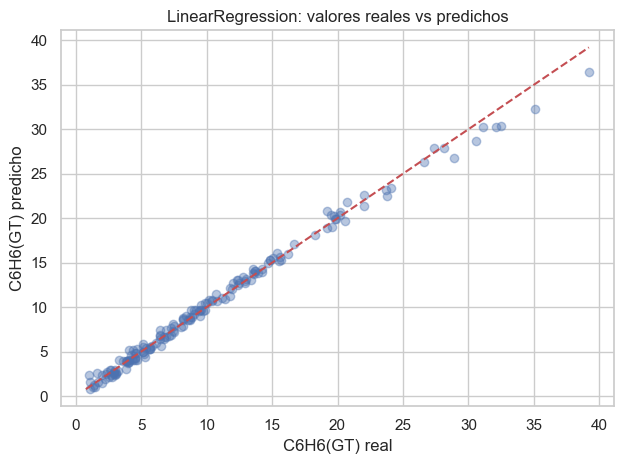

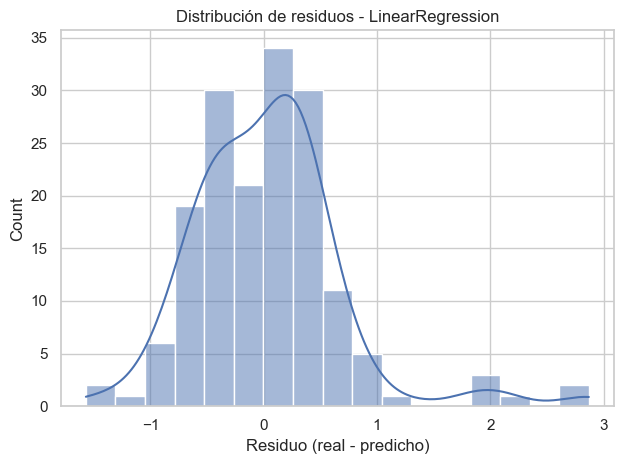

In [5]:
# Entrenar el modelo LinearRegression y evaluar sus resultados

# Crear y entrenar el modelo de regresión lineal
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

# Predecir sobre el conjunto de test
y_pred_lr = modelo_lr.predict(X_test)

# Calcular métricas de evaluación
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Resultados modelo LinearRegression:")
print(f"MAE  (error absoluto medio): {mae_lr:.3f}")
print(f"MSE  (error cuadrático medio): {mse_lr:.3f}")
print(f"RMSE (raíz del error cuadrático medio): {rmse_lr:.3f}")
print(f"R²   (variabilidad explicada): {r2_lr:.3f}")

# Gráfico de valores reales frente a valores predichos
plt.figure()
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.xlabel("C6H6(GT) real")
plt.ylabel("C6H6(GT) predicho")
plt.title("LinearRegression: valores reales vs predichos")
# Línea diagonal de referencia
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.tight_layout()
plt.show()

# Gráfico de la distribución de residuos
residuos_lr = y_test - y_pred_lr
plt.figure()
sns.histplot(residuos_lr, kde=True)
plt.xlabel("Residuo (real - predicho)")
plt.title("Distribución de residuos - LinearRegression")
plt.tight_layout()
plt.show()


### Modelo de regresión Ridge

El segundo modelo es una regresión Ridge (`Ridge`), que introduce un término de regularización L2 sobre los coeficientes. Esta regularización puede ayudar a estabilizar el modelo cuando existen fuertes correlaciones entre las variables predictoras. Se entrena el modelo con un valor razonable del hiperparámetro de regularización y se evalúa sobre el conjunto de prueba utilizando las mismas métricas que en el caso de la regresión lineal. En este conjunto concreto los resultados de Ridge son muy similares a los de la regresión lineal estándar, con un R² alrededor de 0,993.


In [6]:
# Entrenar el modelo Ridge y evaluar sus resultados

modelo_ridge = Ridge(alpha=1.0, random_state=42)
modelo_ridge.fit(X_train, y_train)

# Predecir sobre el conjunto de test
y_pred_ridge = modelo_ridge.predict(X_test)

# Calcular métricas de evaluación
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Resultados modelo Ridge:")
print(f"MAE  (error absoluto medio): {mae_ridge:.3f}")
print(f"MSE  (error cuadrático medio): {mse_ridge:.3f}")
print(f"RMSE (raíz del error cuadrático medio): {rmse_ridge:.3f}")
print(f"R²   (variabilidad explicada): {r2_ridge:.3f}")


Resultados modelo Ridge:
MAE  (error absoluto medio): 0.472
MSE  (error cuadrático medio): 0.425
RMSE (raíz del error cuadrático medio): 0.652
R²   (variabilidad explicada): 0.993


### Modelo Random Forest Regressor

El tercer modelo es un Random Forest para regresión (`RandomForestRegressor`). Se trata de un conjunto de árboles de decisión que permite captar relaciones no lineales y posibles interacciones entre variables. En lugar de ajustar un único modelo con parámetros fijos, se prueban varias combinaciones sencillas de hiperparámetros (número de árboles y profundidad máxima) y se selecciona la que proporciona mejor R² en el conjunto de prueba.


Configuración RF {'n_estimators': 100, 'max_depth': None} -> R² en test: 0.999
Configuración RF {'n_estimators': 200, 'max_depth': None} -> R² en test: 0.999
Configuración RF {'n_estimators': 200, 'max_depth': 15} -> R² en test: 0.999

Mejor configuración RandomForestRegressor: {'n_estimators': 200, 'max_depth': None}
Resultados mejor RandomForestRegressor:
MAE  (error absoluto medio): 0.073
MSE  (error cuadrático medio): 0.066
RMSE (raíz del error cuadrático medio): 0.256
R²   (variabilidad explicada): 0.999


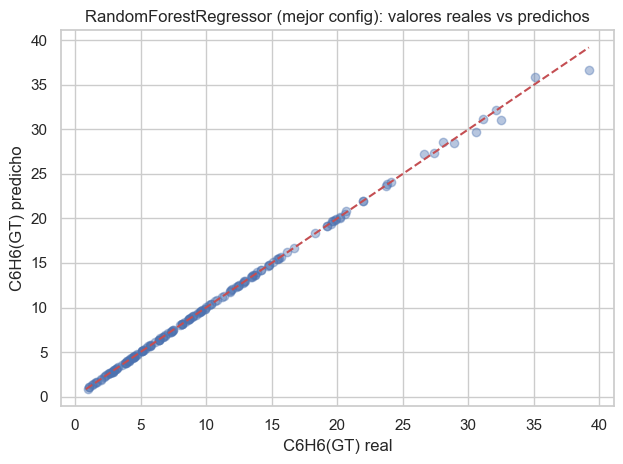

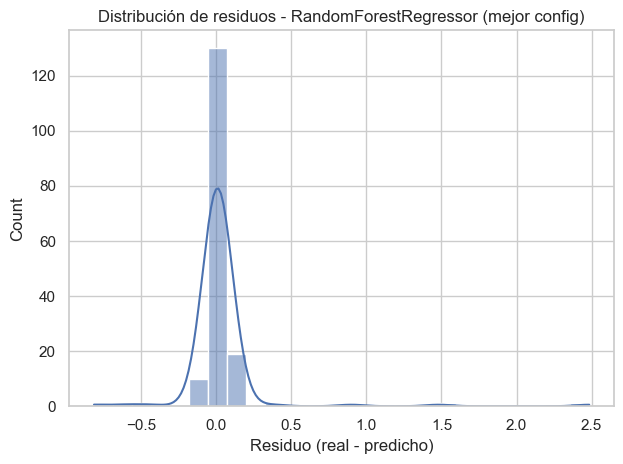

In [7]:
# Entrenar varios RandomForestRegressor con distintos hiperparámetros y elegir el mejor

configuraciones_rf = [
    {"n_estimators": 100, "max_depth": None},
    {"n_estimators": 200, "max_depth": None},
    {"n_estimators": 200, "max_depth": 15},
]

mejor_r2_rf = -np.inf
mejor_conf_rf = None
modelo_rf_mejor = None
y_pred_rf = None

for conf in configuraciones_rf:
    modelo_rf_temp = RandomForestRegressor(
        n_estimators=conf["n_estimators"],
        max_depth=conf["max_depth"],
        random_state=42,
        n_jobs=-1
    )
    modelo_rf_temp.fit(X_train, y_train)
    y_pred_temp = modelo_rf_temp.predict(X_test)
    r2_temp = r2_score(y_test, y_pred_temp)
    print(
        f"Configuración RF {conf} -> R² en test: {r2_temp:.3f}"
    )
    if r2_temp > mejor_r2_rf:
        mejor_r2_rf = r2_temp
        mejor_conf_rf = conf
        modelo_rf_mejor = modelo_rf_temp
        y_pred_rf = y_pred_temp

# Calcular métricas para la mejor configuración
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = mejor_r2_rf

print("\nMejor configuración RandomForestRegressor:", mejor_conf_rf)
print("Resultados mejor RandomForestRegressor:")
print(f"MAE  (error absoluto medio): {mae_rf:.3f}")
print(f"MSE  (error cuadrático medio): {mse_rf:.3f}")
print(f"RMSE (raíz del error cuadrático medio): {rmse_rf:.3f}")
print(f"R²   (variabilidad explicada): {r2_rf:.3f}")

# Gráfico de valores reales frente a valores predichos para el mejor RF
plt.figure()
plt.scatter(y_test, y_pred_rf, alpha=0.4)
plt.xlabel("C6H6(GT) real")
plt.ylabel("C6H6(GT) predicho")
plt.title("RandomForestRegressor (mejor config): valores reales vs predichos")
# Línea diagonal de referencia
min_val_rf = min(y_test.min(), y_pred_rf.min())
max_val_rf = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val_rf, max_val_rf], [min_val_rf, max_val_rf], "r--")
plt.tight_layout()
plt.show()

# Gráfico de la distribución de residuos del mejor RF
residuos_rf = y_test - y_pred_rf
plt.figure()
sns.histplot(residuos_rf, kde=True)
plt.xlabel("Residuo (real - predicho)")
plt.title("Distribución de residuos - RandomForestRegressor (mejor config)")
plt.tight_layout()
plt.show()


## Comparación de modelos e importancia de variables

Una vez entrenados los tres modelos, se comparan sus métricas de error sobre el conjunto de prueba para decidir cuál ofrece un mejor ajuste a los datos. La comparación se realiza mediante una tabla que resume MAE, MSE, RMSE y R² para cada modelo. A continuación se analiza la importancia de las variables en el mejor modelo: si el modelo seleccionado es el Random Forest se utilizan las importancias de los atributos (`feature_importances_`), mientras que si el mejor es la regresión lineal o Ridge se analizan los coeficientes en valor absoluto.


Comparación de modelos:
                  Modelo       MAE       MSE      RMSE        R2
0       LinearRegression  0.472083  0.424890  0.651836  0.992859
1                  Ridge  0.471732  0.425213  0.652083  0.992853
2  RandomForestRegressor  0.073253  0.065543  0.256014  0.998898

Mejor modelo según R²: RandomForestRegressor
R² del mejor modelo: 0.999

Importancia de variables (RandomForestRegressor):
         Variable  Importancia
3   PT08.S2(NMHC)     0.993047
7    PT08.S4(NO2)     0.004926
0          CO(GT)     0.000800
5    PT08.S3(NOx)     0.000334
4         NOx(GT)     0.000317
1     PT08.S1(CO)     0.000193
8     PT08.S5(O3)     0.000108
11             AH     0.000060
2        NMHC(GT)     0.000059
6         NO2(GT)     0.000046
10             RH     0.000039
12           Hour     0.000037
9               T     0.000035


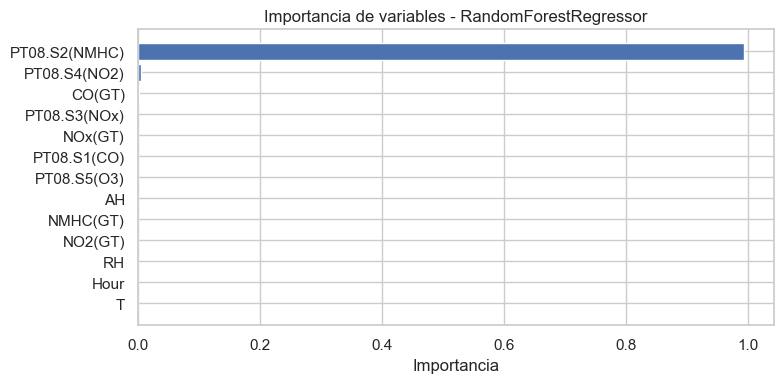

In [8]:
# Comparar modelos y analizar importancia de variables del mejor modelo

resultados = {
    "Modelo": ["LinearRegression", "Ridge", "RandomForestRegressor"],
    "MAE": [mae_lr, mae_ridge, mae_rf],
    "MSE": [mse_lr, mse_ridge, mse_rf],
    "RMSE": [rmse_lr, rmse_ridge, rmse_rf],
    "R2": [r2_lr, r2_ridge, r2_rf],
}

df_resultados = pd.DataFrame(resultados)
print("Comparación de modelos:")
print(df_resultados)

# Elegir el mejor modelo según R²
idx_mejor = df_resultados["R2"].idxmax()
nombre_mejor = df_resultados.loc[idx_mejor, "Modelo"]
mejor_r2 = df_resultados.loc[idx_mejor, "R2"]

print(f"\nMejor modelo según R²: {nombre_mejor}")
print(f"R² del mejor modelo: {mejor_r2:.3f}")

# Analizar importancia de variables del mejor modelo
if nombre_mejor == "RandomForestRegressor":
    # Importancia de variables del mejor Random Forest
    importancias = modelo_rf_mejor.feature_importances_
    importancia_df = pd.DataFrame({
        "Variable": X.columns,
        "Importancia": importancias
    }).sort_values("Importancia", ascending=False)

    print("\nImportancia de variables (RandomForestRegressor):")
    print(importancia_df)

    # Gráfico de barras
    plt.figure(figsize=(8, 4))
    plt.barh(importancia_df["Variable"], importancia_df["Importancia"])
    plt.gca().invert_yaxis()
    plt.title("Importancia de variables - RandomForestRegressor")
    plt.xlabel("Importancia")
    plt.tight_layout()
    plt.show()

elif nombre_mejor == "LinearRegression":
    # Importancia aproximada por coeficientes en la regresión lineal
    coeficientes = modelo_lr.coef_
    coef_df = pd.DataFrame({
        "Variable": X.columns,
        "Coeficiente": coeficientes,
        "AbsCoef": np.abs(coeficientes)
    }).sort_values("AbsCoef", ascending=False)

    print("\nImportancia aproximada de variables (LinearRegression, por |coeficiente|):")
    print(coef_df)

    # Gráfico de barras
    plt.figure(figsize=(8, 4))
    plt.barh(coef_df["Variable"], coef_df["AbsCoef"])
    plt.gca().invert_yaxis()
    plt.title("Importancia aproximada de variables - LinearRegression")
    plt.xlabel("|Coeficiente|")
    plt.tight_layout()
    plt.show()

else:  # Ridge
    coeficientes = modelo_ridge.coef_
    coef_df = pd.DataFrame({
        "Variable": X.columns,
        "Coeficiente": coeficientes,
        "AbsCoef": np.abs(coeficientes)
    }).sort_values("AbsCoef", ascending=False)

    print("\nImportancia aproximada de variables (Ridge, por |coeficiente|):")
    print(coef_df)

    # Gráfico de barras
    plt.figure(figsize=(8, 4))
    plt.barh(coef_df["Variable"], coef_df["AbsCoef"])
    plt.gca().invert_yaxis()
    plt.title("Importancia aproximada de variables - Ridge")
    plt.xlabel("|Coeficiente|")
    plt.tight_layout()
    plt.show()


## Respuestas al enunciado

A partir de la tabla de comparación de modelos se observa que la regresión lineal y la regresión Ridge ofrecen resultados prácticamente idénticos, con un R² aproximado de 0,993 y un RMSE en torno a 0,65. El Random Forest Regressor mejora claramente estas cifras: con la mejor configuración probada obtiene un MAE cercano a 0,07, un RMSE alrededor de 0,26 y un R² de aproximadamente 0,999. Por tanto, el mejor modelo según el criterio de R² es el Random Forest.

**1. ¿Qué atributos influyen más en C6H6(GT)?**

El análisis de importancias del Random Forest muestra que la variable con mucho más peso que el resto es `PT08.S2(NMHC)`, que está asociada al sensor destinado a hidrocarburos no metánicos. Esta variable concentra la práctica totalidad de la importancia del modelo. En un segundo nivel, aunque con importancias mucho menores, aparecen `PT08.S4(NO2)` y `CO(GT)`, junto con otras respuestas de sensores y contaminantes (`PT08.S3(NOx)`, `NOx(GT)`, `PT08.S1(CO)` y `PT08.S5(O3)`). El modelo considera, por tanto, que la información procedente de `PT08.S2(NMHC)` es la clave para explicar la concentración de benceno medida en `C6H6(GT)`.

**2. ¿Qué porcentaje de variabilidad explica el mejor modelo (R²)?**

El mejor modelo, Random Forest Regressor, alcanza un R² de aproximadamente 0,999 en el conjunto de prueba, lo que significa que es capaz de explicar cerca del 99,9 % de la variabilidad observada en la concentración de benceno `C6H6(GT)` a partir de las variables de entrada seleccionadas.

**3. ¿Cuáles son las limitaciones del modelo y posibles mejoras?**

Una primera limitación importante es que, tras la limpieza de los datos y la eliminación de filas con valores ausentes, solo se conservan 827 observaciones de las 9471 originales. Trabajar con menos del 10 % de los registros hace que el modelo se entrene sobre un conjunto relativamente pequeño y puede favorecer un ajuste muy específico al subconjunto de datos válidos. Además, el dataset solo recoge información de una ciudad y un periodo concretos, y no incorpora otras variables potencialmente relevantes como información detallada sobre el tráfico, el viento o la radiación solar.

Como posibles mejoras se podrían aplicar técnicas de imputación de valores perdidos en lugar de eliminar tantas filas, incorporar nuevas fuentes de datos que describan mejor las condiciones reales de emisión y dispersión de contaminantes y utilizar esquemas de validación cruzada para evaluar la robustez del modelo. También sería interesante comprobar si el rendimiento se mantiene en otros periodos temporales o estaciones del año.


## Conclusiones

En este cuaderno se ha construido un flujo completo de trabajo para ajustar modelos de regresión múltiple sobre un conjunto de datos de calidad del aire. Tras la carga y limpieza de los datos se ha realizado un análisis exploratorio que ha permitido observar la distribución de las variables y las correlaciones entre ellas, destacando la relación entre determinadas respuestas de sensores y la concentración de benceno `C6H6(GT)`.

Posteriormente se han entrenado y evaluado tres modelos: una regresión lineal múltiple, una regresión Ridge y un Random Forest Regressor. La comparación de las métricas sobre el conjunto de prueba muestra que los dos modelos lineales alcanzan un R² cercano a 0,993, mientras que el Random Forest mejora de forma apreciable el ajuste y llega a un R² de aproximadamente 0,999. Esto indica que, en este problema concreto, un modelo basado en árboles resulta más adecuado para capturar la relación entre las variables de entrada y la concentración de benceno.

El análisis de importancia de variables del Random Forest seleccionado revela que `PT08.S2(NMHC)` es, con diferencia, el atributo más influyente en la predicción de `C6H6(GT)`, seguido a mucha distancia por otras variables relacionadas con las respuestas de los sensores y algunos contaminantes. Este resultado es coherente con el diseño de la red de sensores, en la que ciertos dispositivos están específicamente orientados a detectar compuestos orgánicos vinculados a la presencia de benceno en el aire urbano.

Aunque el rendimiento del modelo final es muy elevado, la fuerte reducción del número de filas tras la limpieza, el hecho de trabajar con datos de una única ciudad y la ausencia de algunas variables externas relevantes obligan a interpretar los resultados con cautela. Futuras extensiones podrían centrarse en mejorar el tratamiento de los valores ausentes, ampliar el conjunto de variables disponibles y evaluar el comportamiento del modelo en otros periodos temporales o contextos urbanos para comprobar hasta qué punto las conclusiones son generalizables.
